<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/GAN/CGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN (Conditional GAN)



## Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 42.6MB/s 


In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [23]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class Generator(nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Generator, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100 + class_num, (in_height // 16) * (in_width // 16) * dim * 8, bias=False),
            Reshape(dim * 8, in_height // 16, in_width // 16),
            nn.BatchNorm2d(dim * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 8, dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 4, dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 2, dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, in_channel, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, x_condition):
        x = torch.cat([x, x_condition], dim=1)
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Discriminator, self).__init__()

        self.module = nn.Sequential(
            nn.Conv2d(in_channel + class_num, dim, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 2, dim * 4, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 4, dim * 8, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear((in_height // 16) * (in_width // 16) * dim * 8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, x_condition):
        x = torch.cat([x, x_condition], dim=1)
        return self.module(x)



class Generator_MNIST(nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=28, in_width=28, in_channel=1):
        super(Generator_MNIST, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100 + class_num, (in_height // 4) * (in_width // 4) * dim * 2, bias=False),
            Reshape(dim * 2, in_height // 4, in_width // 4),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 2, dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, in_channel, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, x_condition):
        x = torch.cat([x, x_condition], dim=1)
        return self.module(x)


class Discriminator_MNIST(torch.nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=28, in_width=28, in_channel=1):
        super(Discriminator_MNIST, self).__init__()

        self.module = nn.Sequential(
            nn.Conv2d(in_channel + class_num, dim, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear((in_height // 4) * (in_width // 4) * dim * 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, x_condition):
        x = torch.cat([x, x_condition], dim=1)
        return self.module(x)

# Dataset

In [27]:
class MnistDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [5]:
class Cifar10Dataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [6]:
transforms_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [24]:
def show_sample(Xs, show_num=10, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(f"class {i + 1}")
        plt.axis('off')
        
    plt.show()

def show_sample_MNIST(Xs, show_num=10, name="input"):
    Xs = Xs.detach().cpu().numpy()[:, 0]
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(f"class {i + 1}")
        plt.axis('off')
        
    plt.show()

In [16]:
def train():
    train_models = []
    train_model_paths = []

    EPOCH = 100
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 256

    train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = Cifar10Dataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator().to(device)
    dis = Discriminator().to(device)

    criterion = nn.BCELoss()
    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.9))
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.9))

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_d.zero_grad()
            opt_g.zero_grad()

            xs = batch[0].to(device)
            ys = batch[1]

            _batch_size = len(xs)

            x_conditions = torch.zeros([_batch_size, 10]).to(device)
            x_conditions[range(_batch_size), ys] = 1

            x_conditions_img = torch.zeros([_batch_size, 10, IN_HEIGHT, IN_WIDTH]).to(device)
            x_conditions_img[range(_batch_size), ys] = 1

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            # real x
            y_real = dis(xs, x_conditions_img)
            loss_real = criterion(y_real, ones)

            # fake x
            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs, x_conditions)
            y_fake = dis(x_fake, x_conditions_img)
            loss_fake = criterion(y_fake, zeros)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            opt_d.step()

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs, x_conditions)
            y_fake = dis(x_fake, x_conditions_img)
            loss_g = criterion(y_fake, ones)
            loss_g.backward()
            opt_g.step()

            tr_loss_d += loss_d.item() / train_n
            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 20 == 0:
            x_conditions = torch.zeros([10, 10]).to(device)
            x_conditions[range(10), range(10)] = 1

            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            x_fake = gen(zs, x_conditions)
            show_sample(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths


Files already downloaded and verified
epoch:1/100 [tra]loss-d:0.9252 loss-g:1.8631 [time]tra:66.91sec
epoch:2/100 [tra]loss-d:1.1278 loss-g:1.2727 [time]tra:69.05sec
epoch:3/100 [tra]loss-d:1.2520 loss-g:1.0453 [time]tra:70.61sec
epoch:4/100 [tra]loss-d:1.2353 loss-g:1.0278 [time]tra:71.54sec
epoch:5/100 [tra]loss-d:1.2061 loss-g:1.1512 [time]tra:71.77sec
epoch:6/100 [tra]loss-d:1.1378 loss-g:1.2530 [time]tra:71.59sec
epoch:7/100 [tra]loss-d:1.0835 loss-g:1.3993 [time]tra:72.00sec
epoch:8/100 [tra]loss-d:1.0505 loss-g:1.5287 [time]tra:71.61sec
epoch:9/100 [tra]loss-d:1.0786 loss-g:1.6067 [time]tra:71.68sec
epoch:10/100 [tra]loss-d:1.0312 loss-g:1.5353 [time]tra:71.84sec
epoch:11/100 [tra]loss-d:0.9843 loss-g:1.7365 [time]tra:71.98sec
epoch:12/100 [tra]loss-d:1.0108 loss-g:1.6260 [time]tra:71.94sec
epoch:13/100 [tra]loss-d:0.9736 loss-g:1.7027 [time]tra:71.91sec
epoch:14/100 [tra]loss-d:1.0085 loss-g:1.7438 [time]tra:71.86sec
epoch:15/100 [tra]loss-d:0.9820 loss-g:1.7935 [time]tra:71.89

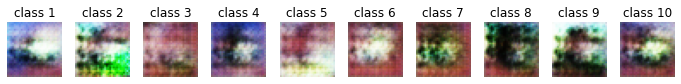

epoch:21/100 [tra]loss-d:0.9301 loss-g:1.9803 [time]tra:72.10sec
epoch:22/100 [tra]loss-d:0.9188 loss-g:2.0648 [time]tra:72.12sec
epoch:23/100 [tra]loss-d:0.8506 loss-g:2.1436 [time]tra:72.08sec
epoch:24/100 [tra]loss-d:0.8739 loss-g:2.1005 [time]tra:72.19sec
epoch:25/100 [tra]loss-d:0.8362 loss-g:2.2386 [time]tra:72.19sec
epoch:26/100 [tra]loss-d:0.8722 loss-g:2.2134 [time]tra:72.36sec
epoch:27/100 [tra]loss-d:0.7987 loss-g:2.3527 [time]tra:72.17sec
epoch:28/100 [tra]loss-d:0.8183 loss-g:2.4639 [time]tra:72.05sec
epoch:29/100 [tra]loss-d:0.7980 loss-g:2.4789 [time]tra:71.79sec
epoch:30/100 [tra]loss-d:0.7579 loss-g:2.5751 [time]tra:71.95sec
epoch:31/100 [tra]loss-d:0.7733 loss-g:2.6489 [time]tra:72.38sec
epoch:32/100 [tra]loss-d:0.7563 loss-g:2.5598 [time]tra:72.29sec
epoch:33/100 [tra]loss-d:0.7356 loss-g:2.7272 [time]tra:72.35sec
epoch:34/100 [tra]loss-d:0.7150 loss-g:2.7346 [time]tra:72.34sec
epoch:35/100 [tra]loss-d:0.6965 loss-g:2.6648 [time]tra:72.36sec
epoch:36/100 [tra]loss-d:

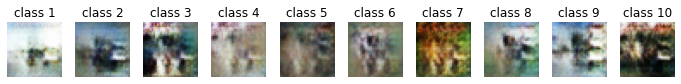

epoch:41/100 [tra]loss-d:0.6731 loss-g:3.1007 [time]tra:72.28sec
epoch:42/100 [tra]loss-d:0.6570 loss-g:3.0503 [time]tra:72.32sec
epoch:43/100 [tra]loss-d:0.6529 loss-g:3.1892 [time]tra:71.99sec
epoch:44/100 [tra]loss-d:0.6596 loss-g:3.0590 [time]tra:71.97sec
epoch:45/100 [tra]loss-d:0.6292 loss-g:3.1729 [time]tra:72.15sec
epoch:46/100 [tra]loss-d:0.6273 loss-g:3.1851 [time]tra:72.21sec
epoch:47/100 [tra]loss-d:0.6329 loss-g:3.0983 [time]tra:72.33sec
epoch:48/100 [tra]loss-d:0.6422 loss-g:3.0975 [time]tra:72.03sec
epoch:49/100 [tra]loss-d:0.6210 loss-g:3.2226 [time]tra:71.90sec
epoch:50/100 [tra]loss-d:0.6173 loss-g:3.2979 [time]tra:71.84sec
epoch:51/100 [tra]loss-d:0.5825 loss-g:3.2561 [time]tra:71.70sec
epoch:52/100 [tra]loss-d:0.5794 loss-g:3.4565 [time]tra:71.83sec
epoch:53/100 [tra]loss-d:0.5983 loss-g:3.3419 [time]tra:72.12sec
epoch:54/100 [tra]loss-d:0.5544 loss-g:3.5105 [time]tra:72.06sec
epoch:55/100 [tra]loss-d:0.5552 loss-g:3.3979 [time]tra:72.15sec
epoch:56/100 [tra]loss-d:

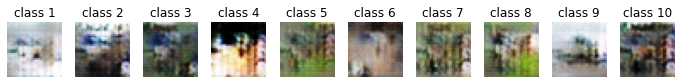

epoch:61/100 [tra]loss-d:0.5261 loss-g:3.7074 [time]tra:71.81sec
epoch:62/100 [tra]loss-d:0.5701 loss-g:3.4534 [time]tra:71.90sec
epoch:63/100 [tra]loss-d:0.5786 loss-g:3.5634 [time]tra:71.74sec
epoch:64/100 [tra]loss-d:0.5544 loss-g:3.5558 [time]tra:71.70sec
epoch:65/100 [tra]loss-d:0.5537 loss-g:3.4760 [time]tra:71.68sec
epoch:66/100 [tra]loss-d:0.5552 loss-g:3.5868 [time]tra:71.85sec
epoch:67/100 [tra]loss-d:0.5238 loss-g:3.7304 [time]tra:72.00sec
epoch:68/100 [tra]loss-d:0.5781 loss-g:3.5064 [time]tra:72.21sec
epoch:69/100 [tra]loss-d:0.5685 loss-g:3.4163 [time]tra:71.59sec
epoch:70/100 [tra]loss-d:0.5434 loss-g:3.5931 [time]tra:72.03sec
epoch:71/100 [tra]loss-d:0.5328 loss-g:3.6995 [time]tra:72.10sec
epoch:72/100 [tra]loss-d:0.5758 loss-g:3.4473 [time]tra:72.22sec
epoch:73/100 [tra]loss-d:0.4994 loss-g:3.8474 [time]tra:72.24sec
epoch:74/100 [tra]loss-d:0.5638 loss-g:3.6376 [time]tra:72.28sec
epoch:75/100 [tra]loss-d:0.5607 loss-g:3.5647 [time]tra:71.99sec
epoch:76/100 [tra]loss-d:

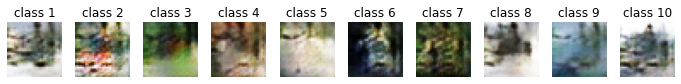

epoch:81/100 [tra]loss-d:0.5405 loss-g:3.6082 [time]tra:71.88sec
epoch:82/100 [tra]loss-d:0.5421 loss-g:3.5417 [time]tra:71.65sec
epoch:83/100 [tra]loss-d:0.4876 loss-g:4.0231 [time]tra:71.60sec
epoch:84/100 [tra]loss-d:0.5131 loss-g:3.8022 [time]tra:71.58sec
epoch:85/100 [tra]loss-d:0.5325 loss-g:3.6691 [time]tra:71.70sec
epoch:86/100 [tra]loss-d:0.5452 loss-g:3.6845 [time]tra:71.80sec
epoch:87/100 [tra]loss-d:0.5380 loss-g:3.7368 [time]tra:71.66sec
epoch:88/100 [tra]loss-d:0.5018 loss-g:3.8432 [time]tra:71.63sec
epoch:89/100 [tra]loss-d:0.5299 loss-g:3.7613 [time]tra:71.61sec
epoch:90/100 [tra]loss-d:0.5412 loss-g:3.6034 [time]tra:71.72sec
epoch:91/100 [tra]loss-d:0.5373 loss-g:3.6517 [time]tra:71.87sec
epoch:92/100 [tra]loss-d:0.5124 loss-g:3.7978 [time]tra:71.84sec
epoch:93/100 [tra]loss-d:0.5226 loss-g:3.7189 [time]tra:72.04sec
epoch:94/100 [tra]loss-d:0.5210 loss-g:3.6274 [time]tra:72.11sec
epoch:95/100 [tra]loss-d:0.5246 loss-g:3.8939 [time]tra:72.19sec
epoch:96/100 [tra]loss-d:

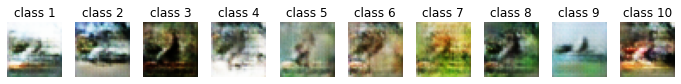

model saved to >> model_epoch100.pth



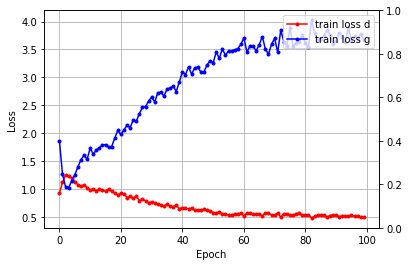

In [17]:
train_models, train_model_paths = train()

# Test

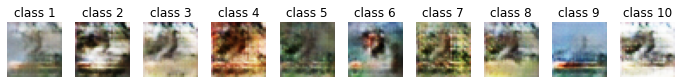

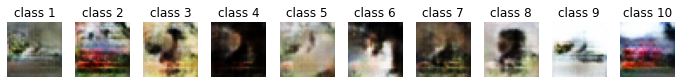

In [19]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            x_conditions = torch.zeros([10, 10]).to(device)
            x_conditions[range(10), range(10)] = 1

            xs = model(zs, x_conditions)
            show_sample(xs, name="output")

test(train_models)

# MNIST train

epoch:1/100 [tra]loss-d:0.1737 loss-g:6.4710 [time]tra:11.63sec
epoch:2/100 [tra]loss-d:1.2230 loss-g:1.4851 [time]tra:11.76sec
epoch:3/100 [tra]loss-d:1.1893 loss-g:0.9555 [time]tra:11.92sec
epoch:4/100 [tra]loss-d:1.2244 loss-g:0.8718 [time]tra:11.70sec
epoch:5/100 [tra]loss-d:1.2303 loss-g:0.8649 [time]tra:11.57sec
epoch:6/100 [tra]loss-d:1.1115 loss-g:0.9585 [time]tra:11.59sec
epoch:7/100 [tra]loss-d:1.0818 loss-g:1.0032 [time]tra:11.51sec
epoch:8/100 [tra]loss-d:1.1332 loss-g:0.9739 [time]tra:11.61sec
epoch:9/100 [tra]loss-d:1.1650 loss-g:0.9522 [time]tra:11.62sec
epoch:10/100 [tra]loss-d:1.1829 loss-g:0.9537 [time]tra:11.69sec
epoch:11/100 [tra]loss-d:1.1983 loss-g:0.9410 [time]tra:11.68sec
epoch:12/100 [tra]loss-d:1.2171 loss-g:0.9215 [time]tra:11.65sec
epoch:13/100 [tra]loss-d:1.2282 loss-g:0.9051 [time]tra:11.68sec
epoch:14/100 [tra]loss-d:1.2342 loss-g:0.8940 [time]tra:11.56sec
epoch:15/100 [tra]loss-d:1.2360 loss-g:0.8832 [time]tra:11.53sec
epoch:16/100 [tra]loss-d:1.2381 lo

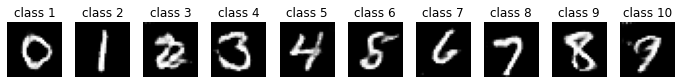

epoch:21/100 [tra]loss-d:1.2581 loss-g:0.8539 [time]tra:11.56sec
epoch:22/100 [tra]loss-d:1.2606 loss-g:0.8479 [time]tra:11.55sec
epoch:23/100 [tra]loss-d:1.2637 loss-g:0.8465 [time]tra:11.59sec
epoch:24/100 [tra]loss-d:1.2651 loss-g:0.8453 [time]tra:11.56sec
epoch:25/100 [tra]loss-d:1.2660 loss-g:0.8387 [time]tra:11.54sec
epoch:26/100 [tra]loss-d:1.2639 loss-g:0.8368 [time]tra:11.59sec
epoch:27/100 [tra]loss-d:1.2649 loss-g:0.8389 [time]tra:11.60sec
epoch:28/100 [tra]loss-d:1.2655 loss-g:0.8389 [time]tra:11.56sec
epoch:29/100 [tra]loss-d:1.2637 loss-g:0.8369 [time]tra:11.56sec
epoch:30/100 [tra]loss-d:1.2625 loss-g:0.8364 [time]tra:11.56sec
epoch:31/100 [tra]loss-d:1.2642 loss-g:0.8399 [time]tra:11.57sec
epoch:32/100 [tra]loss-d:1.2623 loss-g:0.8396 [time]tra:11.61sec
epoch:33/100 [tra]loss-d:1.2628 loss-g:0.8410 [time]tra:11.59sec
epoch:34/100 [tra]loss-d:1.2610 loss-g:0.8421 [time]tra:11.62sec
epoch:35/100 [tra]loss-d:1.2595 loss-g:0.8438 [time]tra:11.57sec
epoch:36/100 [tra]loss-d:

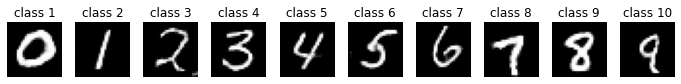

epoch:41/100 [tra]loss-d:1.2532 loss-g:0.8521 [time]tra:11.61sec
epoch:42/100 [tra]loss-d:1.2504 loss-g:0.8486 [time]tra:11.58sec
epoch:43/100 [tra]loss-d:1.2519 loss-g:0.8529 [time]tra:11.58sec
epoch:44/100 [tra]loss-d:1.2524 loss-g:0.8571 [time]tra:11.58sec
epoch:45/100 [tra]loss-d:1.2514 loss-g:0.8583 [time]tra:11.59sec
epoch:46/100 [tra]loss-d:1.2486 loss-g:0.8562 [time]tra:11.58sec
epoch:47/100 [tra]loss-d:1.2464 loss-g:0.8578 [time]tra:11.62sec
epoch:48/100 [tra]loss-d:1.2441 loss-g:0.8607 [time]tra:11.61sec
epoch:49/100 [tra]loss-d:1.2453 loss-g:0.8590 [time]tra:11.56sec
epoch:50/100 [tra]loss-d:1.2424 loss-g:0.8636 [time]tra:11.57sec
epoch:51/100 [tra]loss-d:1.2419 loss-g:0.8640 [time]tra:11.56sec
epoch:52/100 [tra]loss-d:1.2388 loss-g:0.8622 [time]tra:11.56sec
epoch:53/100 [tra]loss-d:1.2398 loss-g:0.8644 [time]tra:11.57sec
epoch:54/100 [tra]loss-d:1.2395 loss-g:0.8654 [time]tra:11.61sec
epoch:55/100 [tra]loss-d:1.2395 loss-g:0.8688 [time]tra:11.58sec
epoch:56/100 [tra]loss-d:

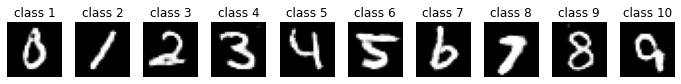

epoch:61/100 [tra]loss-d:1.2301 loss-g:0.8783 [time]tra:11.70sec
epoch:62/100 [tra]loss-d:1.2292 loss-g:0.8788 [time]tra:11.64sec
epoch:63/100 [tra]loss-d:1.2263 loss-g:0.8829 [time]tra:11.66sec
epoch:64/100 [tra]loss-d:1.2254 loss-g:0.8885 [time]tra:11.72sec
epoch:65/100 [tra]loss-d:1.2267 loss-g:0.8870 [time]tra:11.76sec
epoch:66/100 [tra]loss-d:1.2241 loss-g:0.8870 [time]tra:11.71sec
epoch:67/100 [tra]loss-d:1.2225 loss-g:0.8890 [time]tra:11.64sec
epoch:68/100 [tra]loss-d:1.2209 loss-g:0.8944 [time]tra:11.69sec
epoch:69/100 [tra]loss-d:1.2183 loss-g:0.8944 [time]tra:11.64sec
epoch:70/100 [tra]loss-d:1.2170 loss-g:0.8967 [time]tra:11.63sec
epoch:71/100 [tra]loss-d:1.2162 loss-g:0.8983 [time]tra:11.63sec
epoch:72/100 [tra]loss-d:1.2140 loss-g:0.8999 [time]tra:11.66sec
epoch:73/100 [tra]loss-d:1.2140 loss-g:0.9033 [time]tra:11.65sec
epoch:74/100 [tra]loss-d:1.2125 loss-g:0.8994 [time]tra:11.65sec
epoch:75/100 [tra]loss-d:1.2129 loss-g:0.9059 [time]tra:11.69sec
epoch:76/100 [tra]loss-d:

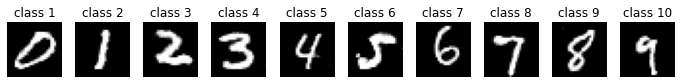

epoch:81/100 [tra]loss-d:1.2013 loss-g:0.9229 [time]tra:11.59sec
epoch:82/100 [tra]loss-d:1.2023 loss-g:0.9180 [time]tra:11.75sec
epoch:83/100 [tra]loss-d:1.1996 loss-g:0.9204 [time]tra:11.69sec
epoch:84/100 [tra]loss-d:1.1975 loss-g:0.9199 [time]tra:11.71sec
epoch:85/100 [tra]loss-d:1.1984 loss-g:0.9242 [time]tra:11.69sec
epoch:86/100 [tra]loss-d:1.1945 loss-g:0.9258 [time]tra:11.65sec
epoch:87/100 [tra]loss-d:1.1966 loss-g:0.9258 [time]tra:11.63sec
epoch:88/100 [tra]loss-d:1.1950 loss-g:0.9303 [time]tra:11.65sec
epoch:89/100 [tra]loss-d:1.1926 loss-g:0.9307 [time]tra:11.70sec
epoch:90/100 [tra]loss-d:1.1946 loss-g:0.9315 [time]tra:11.62sec
epoch:91/100 [tra]loss-d:1.1927 loss-g:0.9326 [time]tra:11.63sec
epoch:92/100 [tra]loss-d:1.1904 loss-g:0.9311 [time]tra:11.61sec
epoch:93/100 [tra]loss-d:1.1936 loss-g:0.9377 [time]tra:11.62sec
epoch:94/100 [tra]loss-d:1.1925 loss-g:0.9374 [time]tra:11.61sec
epoch:95/100 [tra]loss-d:1.1903 loss-g:0.9385 [time]tra:11.60sec
epoch:96/100 [tra]loss-d:

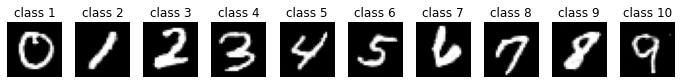

model saved to >> model_epoch100.pth



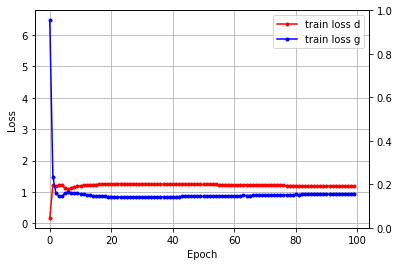

In [31]:
Tdef train_MNIST():
    train_models = []
    train_model_paths = []

    EPOCH = 100
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 256

    train_ds = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.numpy()[..., None].astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = MnistDataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator_MNIST().to(device)
    dis = Discriminator_MNIST().to(device)

    criterion = nn.BCELoss()
    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.9))
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.9))

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_d.zero_grad()
            opt_g.zero_grad()

            xs = batch[0].to(device)
            ys = batch[1]

            _batch_size = len(xs)

            x_conditions = torch.zeros([_batch_size, 10]).to(device)
            x_conditions[range(_batch_size), ys] = 1

            x_conditions_img = torch.zeros([_batch_size, 10, 28, 28]).to(device)
            x_conditions_img[range(_batch_size), ys] = 1

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            # real x
            y_real = dis(xs, x_conditions_img)
            loss_real = criterion(y_real, ones)

            # fake x
            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs, x_conditions)
            y_fake = dis(x_fake, x_conditions_img)
            loss_fake = criterion(y_fake, zeros)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            opt_d.step()

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs, x_conditions)
            y_fake = dis(x_fake, x_conditions_img)
            loss_g = criterion(y_fake, ones)
            loss_g.backward()
            opt_g.step()

            tr_loss_d += loss_d.item() / train_n
            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 20 == 0:
            x_conditions = torch.zeros([10, 10]).to(device)
            x_conditions[range(10), range(10)] = 1

            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            x_fake = gen(zs, x_conditions)
            show_sample_MNIST(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths

train_models, train_model_paths = train_MNIST()

# MNIST test

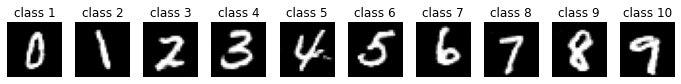

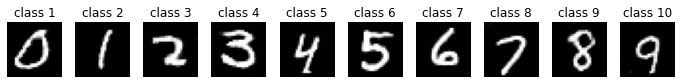

In [32]:
# test
def test_MNIST(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            x_conditions = torch.zeros([10, 10]).to(device)
            x_conditions[range(10), range(10)] = 1

            xs = model(zs, x_conditions)
            show_sample_MNIST(xs, name="output")

test_MNIST(train_models)